# The Julia Opportunistic Network Simulator

In [1]:
#using Pkg
#Pkg.instantiate()

push!(LOAD_PATH, "../src")
push!(LOAD_PATH, "src")

using Random
using DataFrames
using JONS


## Configuration

In [2]:
MOVEMENT_FILE="data/large_1.one"
SCAN_INTERVAL=2.0
NET_RANGE=100
ANIMATION_STEPS = 20.0
VIZ = false
POSLOG = false

false

In [3]:
one_scenario = parse_one_movement(MOVEMENT_FILE)

OneScenario(duration=3600.0, nn=17, w=1000.0, h=1000.0, #movements=18012)

In [4]:
Random.seed!(1)
#plotlyjs()

# configure network
network = NetworkSettings(NET_RANGE, 54000000)

# configure nodes
epidemic = EpidemicRouter(10000, SCAN_INTERVAL)
saw = SprayAndWaitRouter(10000, SCAN_INTERVAL, 7)
nodes = generate_nodes(one_scenario.nn, network, epidemic)

msggenconfig = MessageGeneratorConfig("M", (80, 120), (20.0, 20.0), (6, 15), (17, 17), Burst)
config = Dict()
config["visualize"] = VIZ
config["poslogger"] = POSLOG
#sim = NetSim(last_move_time + 1, (Float32(WORLD_SIZE[1]), Float32(WORLD_SIZE[2])), nodes, movements, MessageGeneratorConfig[msggenconfig], config)
sim = NetSim(one_scenario.duration + 1, (one_scenario.w, one_scenario.h), nodes, one_scenario.movements, MessageGeneratorConfig[msggenconfig], config)

sim_init(sim)
sim_run(sim)

┌ Info: initializing simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:45


┌ Info: real: 3006 milliseconds sim: 3602 rate: 1198.27 s/s
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 3 seconds, 6 milliseconds
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:76


## Results

In [5]:
DataFrame(net_stats(sim))

Row,drop,rx,tx
,Int64,Int64,Int64
1,0,104363,104363


In [6]:
DataFrame(bundle_stats(sim))

Row,aborted,created,delivered,delivery_prob,dropped,dups,hops_avg,latency_avg,overhead_ratio,relayed,removed,started
,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64
1,0,1800,1664,0.924444,0,81287,3.07151,241.187,61.7181,104363,0,105808


In [7]:
sim_viz(sim)

In [8]:
Random.seed!(1)
#plotlyjs()

# configure network
network = NetworkSettings(NET_RANGE, 54000000)

# configure nodes
routers = [EpidemicRouter(10000, SCAN_INTERVAL), 
  SprayAndWaitRouter(10000, SCAN_INTERVAL, 7), 
  SprayAndWaitRouter(10000, SCAN_INTERVAL, 2),
  SprayAndWaitRouter(10000, SCAN_INTERVAL, 1)]
run_idx = 1

dfs = []

for r in routers
  println("#run ", run_idx, " w/ router: ", r)
  r_strategy = string(r)
  if r_strategy == "SprayAndWait"
    r_strategy = "SprayAndWait_" * string(r.core.config["copies"])
  end
  run_idx += 1

  nodes = generate_nodes(one_scenario.nn, network, r)
  
  msggenconfig = MessageGeneratorConfig("M", (80, 120), (20.0, 20.0), (6, 15), (17, 17), Burst)
  config = Dict()
  config["visualize"] = VIZ
  config["poslogger"] = POSLOG
  #sim = NetSim(last_move_time + 1, (Float32(WORLD_SIZE[1]), Float32(WORLD_SIZE[2])), nodes, movements, MessageGeneratorConfig[msggenconfig], config)
  sim = NetSim(one_scenario.duration + 1, (one_scenario.w, one_scenario.h), nodes, one_scenario.movements, MessageGeneratorConfig[msggenconfig], config)
  
  sim_init(sim)
  sim_run(sim)

  run_df = DataFrame(bundle_stats(sim))
  colname = "Strategy"
  #run_df[!, colname] = string(r)
  insertcols!(run_df, 1, colname => r_strategy)
  push!(dfs, run_df)
end

df = popfirst!(dfs)
for d in dfs
  df = vcat(df, d)
end
df

#run 1 w/ router: Epidemic


┌ Info: initializing simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:45


┌ Info: real: 2439 milliseconds sim: 3602 rate: 1476.83 s/s
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 2 seconds, 439 milliseconds
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:76


#run 2 w/ router: SprayAndWait


┌ Info: initializing simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:45


#run 3 w/ router: SprayAndWait


┌ Info: real: 884 milliseconds sim: 3602 rate: 4074.66 s/s
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 884 milliseconds
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:45


#run 4 w/ router: SprayAndWait


┌ Info: real: 547 milliseconds sim: 3602 rate: 6585.01 s/s
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 547 milliseconds
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:45


┌ Info: real: 300 milliseconds sim: 3602 rate: 12006.67 s/s
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 300 milliseconds
└ @ JONS /Users/lab/src/scratch/JONS.jl/src/simulation.jl:76


Row,Strategy,aborted,created,delivered,delivery_prob,dropped,dups,hops_avg,latency_avg,overhead_ratio,relayed,removed,started
,String,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64
1,Epidemic,0,1800,1664,0.924444,0,81287,3.07151,241.187,61.7181,104363,0,105808
2,SprayAndWait_7,0,1800,1637,0.909444,0,4836,2.0,290.598,7.01833,13126,0,13217
3,SprayAndWait_2,0,1800,1612,0.895556,0,0,2.0,350.298,1.02916,3271,0,3291
4,SprayAndWait_1,0,1800,0,0.0,0,0,NaN,NaN,NaN,0,0,0


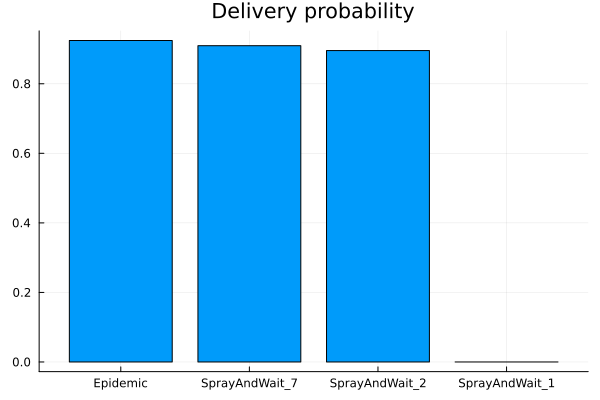

In [9]:
using Plots
bar(df[!,"Strategy"], df[!, "delivery_prob"], label="")
title!("Delivery probability")

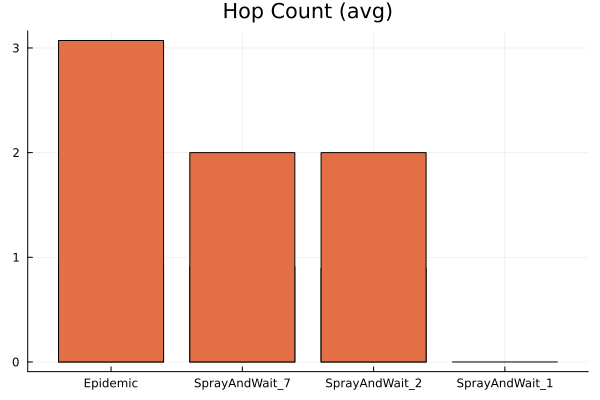

In [10]:
bar!(df[!,"Strategy"], df[!, "hops_avg"], label="")
title!("Hop Count (avg)")


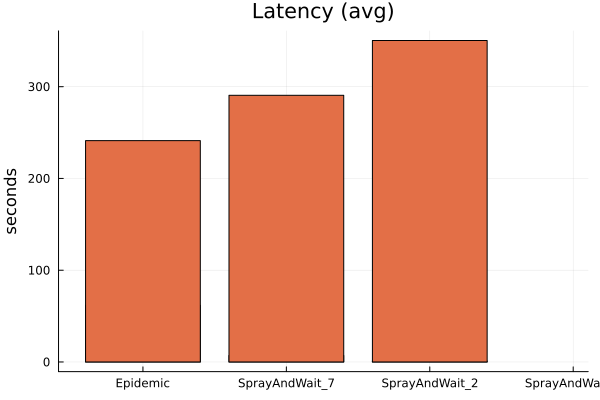

In [14]:
bar!(df[!,"Strategy"], df[!, "latency_avg"], label="")
title!("Latency (avg)")
ylabel!("seconds")

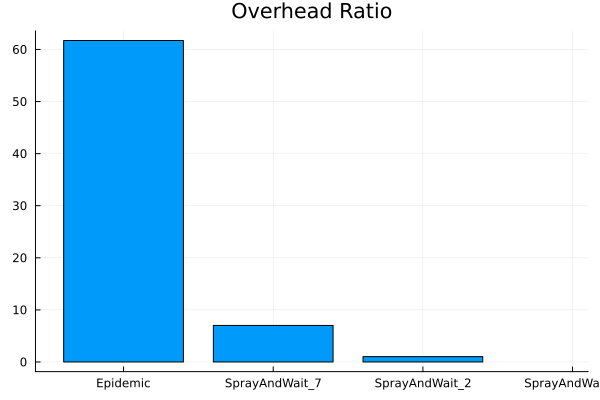

In [15]:
bar(df[!,"Strategy"], df[!, "overhead_ratio"], label="")
title!("Overhead Ratio")
